In [1]:
import time
import hydra
from hydra.utils import to_absolute_path
import torch
import sys
import os
import torch.nn as nn

import argparse

from dgl.dataloading import GraphDataLoader
import dgl
from omegaconf import DictConfig

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel

#project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', ''))
#sys.path.append(project_path)
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset
from modulus.distributed.manager import DistributedManager
from modulus.launch.logging import (
    PythonLogger,
    RankZeroLoggingWrapper,
    initialize_wandb,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNet import MeshGraphNet


In [2]:
from hydra.utils import to_absolute_path

In [3]:
import numpy as np

In [4]:
class TestRollout:
    def __init__(self, cfg: DictConfig, logger: PythonLogger):
        self.num_test_time_steps = cfg.num_test_time_steps
        
        # set device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using {self.device} device")
        
        # instantiate dataset
        self.dataset = TelemacDataset(
            name="telemac_test",
            data_dir=to_absolute_path(cfg.data_dir),
            dynamic_data_file= to_absolute_path(cfg.dynamic_dir),
            split="test",
            num_samples=cfg.num_test_samples,
            num_steps=cfg.num_test_time_steps,
            ckpt_path=cfg.ckpt_path,
            stride=cfg.timestep,
            starting_ts = cfg.starting_ts
        )
        
        # instantiate dataloader
        self.dataloader = GraphDataLoader(
            self.dataset,
            batch_size=1,  
            shuffle=False,
            drop_last=False,
        )
        print(len(self.dataloader))

        # instantiate the model
        self.model = MeshGraphNet(
            cfg.num_input_features,
            cfg.num_edge_features,
            cfg.num_output_features,
            processor_size=cfg.mp_layers,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=cfg.do_concat_trick,
            num_processor_checkpoint_segments=cfg.num_processor_checkpoint_segments,
        )
        if cfg.jit:
            self.model = torch.jit.script(self.model).to(self.device)
        else:
            self.model = self.model.to(self.device)

        # enable train mode
        self.model.eval()

        # load checkpoint
        load_checkpoint(
            to_absolute_path(cfg.ckpt_path),
            models=self.model,
            device=self.device,
        )
        self.model = self.model.to(self.device)
        self.var_identifier = {"h": 0, "u": 1, "v": 2}
        
        #get the stats needed to denormalize and normalize
        node_stats =  self.dataset.node_stats
        self.h_u_v_i_0_mean = np.array([node_stats['h'].item(),node_stats['u'].item(),node_stats['v'].item()])
        self.h_u_v_i_0_std = np.array([node_stats['h_std'].item(),node_stats['u_std'].item(),node_stats['v_std'].item()])

        self.delta_h_u_v_i_diff_mean = np.array([node_stats['delta_h'].item(),node_stats['delta_u'].item(),node_stats['delta_v'].item()])
        self.delta_h_u_v_i_diff_std = np.array([node_stats['delta_h_std'].item(),node_stats['delta_u_std'].item(),node_stats['delta_v_std'].item()])
        
    def predict(self,graph):
        """
        En fonction du graph d'entrée, prédit la sortie du réseau. 
        Dénormalise h,u,v de l'entrée du réseau. 
        Dénormalise la variation prévue (sortie du réseau).
        Dénormalise la variation réelle.
        Retourne la valeur à l'instant t+1 réelle et prévue. 
        """
        
        with torch.no_grad():
                pred = self.model(graph.ndata['x'].to(self.device),graph.edata['x'].to(self.device),graph.to(self.device)).cpu().numpy()
        
        #print(pred)
        #print(graph.ndata['y'])
            
        # denormalize data
        h_u_v_i_0 = self._denormalize_data(graph.ndata['x'][:,6:9].numpy(),self.h_u_v_i_0_mean,self.h_u_v_i_0_std)

        #h_u_v_i_1 = self._denormalize_data(graph.ndata['y'][:,0:3].numpy(),self.delta_h_u_v_i_diff_mean,self.delta_h_u_v_i_diff_std) + h_u_v_i_0
            
        h_u_v_i_1_pred = self._denormalize_data(pred,self.delta_h_u_v_i_diff_mean,self.delta_h_u_v_i_diff_std) + h_u_v_i_0
        
        h_u_v_i_1 = None 
        
        return h_u_v_i_1,h_u_v_i_1_pred,h_u_v_i_0
        
        
    def maj_mask(self,pred,next_step):
        """
        On veut utiliser la prédiction du pas d'avant pour prévoir un pas de temps de plus
        Pour cela on veut remplacer les valeurs prévues à l'instant t sur les boundaries conditions par 
        les valeurs réelle à l'instant t+1
        
        On cherche donc les noeuds concernés avec les q mask et le h_mask 
        
        On remplie le résultat en fonction 
        
        pred et next step sont normalisés
        """

        # On cherches les noeuds suivant leur boundaries conditions 
        self.q_mask = (next_step[:,0:4].numpy() == [0, 0, 1, 0]).all(axis=1)
        self.h_mask = (next_step[:,0:4].numpy() == [0, 1, 0, 0]).all(axis=1)

        result = np.empty_like(next_step)
        
        #pour les valeurs statiques on les récupère dans next pred 
        result[:,0:6] =next_step[:,0:6]
        
        #pour les valeurs dynamiques on récupère dans pred 
        result[:,6:9] = pred
        
        #la ou on a une condition de flux on ajouter huv next step 
        result[self.q_mask,6:9] = next_step[self.q_mask,6:9]
        
        #la ou on a une condition de hauteur on ajoute h next step 
        result[self.h_mask,6:7] = next_step[self.h_mask,6:7]
        return result 
    
#    def predict_from_one(self,unroll_steps=1):
#        main_dataloader = iter(self.dataloader)
#        graph = next(main_dataloader)
#        predict = []
#        groundtruth = []
#        for j in range(unroll_steps):
#            next_graph = next(main_dataloader)
#            
#            _,h_u_v_i_1_pred,_ = self.predict(graph)
#            
#            h_u_v_i_1_pred[h_u_v_i_1_pred[:,0]<5e-3,:] = 0.0
#            
#            h_u_v_i_1_pred_norm = self._normalize_data(h_u_v_i_1_pred,self.h_u_v_i_0_mean,self.h_u_v_i_0_std)
#                
#            #ajoute les bcs 
#            next_step_result = self.maj_mask(h_u_v_i_1_pred_norm,next_graph.ndata['x'])
#           
#            graph.ndata['x'] = torch.tensor(next_step_result)
            
#            predict.append(h_u_v_i_1_pred)
#            groundtruth.append(self._denormalize_data(next_graph.ndata['x'][:,6:9].numpy(),self.h_u_v_i_0_mean,self.h_u_v_i_0_std))
#                
#        return predict,groundtruth
    def predict_unroll(self,unroll_steps=1):
        main_dataloader = iter(self.dataloader)
        predict = []
        groundtruth = []
        origin = []
        for i in range(len(self.dataloader) - unroll_steps):
            # Reset the dataloader to fetch only the graphs needed in the j loop
            current_graphs_loader = GraphDataLoader(
                self.dataset,
                batch_size=1,  
                shuffle=False,
                drop_last=False,
            )
            current_dataloader_iter = iter(current_graphs_loader)
        
            # Advance to the i-th graph in the current_dataloader_iter
            for _ in range(i+1):
                next(current_dataloader_iter)
                
            graph = next(main_dataloader)
            
            for j in range(unroll_steps):
                next_graph = next(current_dataloader_iter)
                #produit des predictions dénormalisées 
                h_u_v_i_1,h_u_v_i_1_pred,h_u_v_i_0 = self.predict(graph)
                
                if j == 0 : 
                    origin.append(h_u_v_i_0)
                    
                noise_filter = h_u_v_i_1_pred[:,0]<1e-2
                
                h_u_v_i_1_pred[noise_filter,:] = 0.0
                
                #normalise la prediction pour la transférer dasn le graphe suivant 
                h_u_v_i_1_pred_norm = self._normalize_data(h_u_v_i_1_pred,self.h_u_v_i_0_mean,self.h_u_v_i_0_std)
                
                #ajoute les bcs 
                next_step_result = self.maj_mask(h_u_v_i_1_pred_norm,next_graph.ndata['x'])
           
                graph.ndata['x'] = torch.tensor(next_step_result)
            
            predict.append(h_u_v_i_1_pred)
            groundtruth.append(self._denormalize_data(next_graph.ndata['x'][:,6:9].numpy(),self.h_u_v_i_0_mean,self.h_u_v_i_0_std))
            

        return predict,groundtruth,origin

    def _denormalize_data(self,tensor,mean,std):
        assert(tensor.shape[1]==mean.shape[0])
        assert(tensor.shape[1]==std.shape[0])
        return tensor*std + mean 
    def _normalize_data(self,tensor,mean,std):
        assert(tensor.shape[1]==mean.shape[0])
        assert(tensor.shape[1]==std.shape[0])
        return (tensor-mean)/std
    
    def get_raw_data(self, idx):
        self.pred_i = [var[:, idx] for var in self.pred]
        self.exact_i = [var[:, idx] for var in self.exact]

        return self.graphs, self.faces, self.pred_i, self.exact_i


In [10]:
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf


# Initialize Hydra and set the configuration directory
with initialize(config_path="../bin/conf"):
    logger = PythonLogger("main")  # General python logger
    logger.file_logging()
    # Compose the configuration using the config name
    cfg = compose(config_name="config_new_dataset_new_multimesh_test")
    
    # Display the configuration (optional)
    print(OmegaConf.to_yaml(cfg))

    # Now call the training function with the composed config
    test = TestRollout(cfg,logger)
    predict,groundtruth,origin = test.predict_unroll(unroll_steps=3)


/tmp/ipykernel_2303623/208949708.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../bin/conf"):
[13:46:32 - main - INFO] Using cuda device


data_dir: /work/m24046/m24046mrcr/dataset_20_min/Multimesh_2_32_True.bin
dynamic_dir: /work/m24046/m24046mrcr/dataset_20_min/TetQ1500inter_chunk/TetQ1500inter_0_30-105.pkl
batch_size: 1
epochs: 3000
mp_layers: 12
num_test_samples: 1
num_test_time_steps: 75
lr: 0.001
lr_decay_rate: 0.985
num_input_features: 9
num_output_features: 3
num_edge_features: 3
timestep: 1
custom_loss: false
starting_ts: 0
use_apex: true
amp: false
jit: false
num_dataloader_workers: 4
do_concat_trick: true
num_processor_checkpoint_segments: 0
recompute_activation: false
ckpt_path: /work/m24046/m24046mrcr/checkpoints_new_dataset_new_multimesh

we are loading
{'h': tensor([0.9846]), 'u': tensor([0.0003]), 'v': tensor([4.1178e-05]), 'strickler': tensor([20.6630]), 'z': tensor([17.5927]), 'delta_h': tensor([-0.0033]), 'delta_u': tensor([-0.0019]), 'delta_v': tensor([-0.0004]), 'h_std': tensor([0.1232]), 'u_std': tensor([0.0159]), 'v_std': tensor([0.0064]), 'strickler_std': tensor([11.6974]), 'z_std': tensor([13.9988

[13:46:33 - checkpoint - INFO] Loaded model state dictionary /work/m24046/m24046mrcr/checkpoints_new_dataset_new_multimesh/MeshGraphNet.0.1440.mdlus to device cuda
[13:46:33 - checkpoint - INFO] Loaded checkpoint file /work/m24046/m24046mrcr/checkpoints_new_dataset_new_multimesh/checkpoint.0.1440.pt to device cuda


75


In [11]:
!ls /work/m24046/m24046mrcr/

TetQ2500inter_1min_chunk	       checkpoints_new_dataset_new_multimesh
TetQ2500inter_1min_multimesh_base.bin  dataset_20_min


In [12]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

mesh_list = ['/work/m24046/m24046mrcr/dataset_20_min/maillage_3.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [13]:
def calculate_csi(predictions, observations, epsilon):
    """
    Calcule le Critical Success Index (CSI) entre deux tableaux de prédictions et d'observations.
    
    Parameters:
    predictions (numpy.ndarray): Un tableau numpy contenant les prédictions.
    observations (numpy.ndarray): Un tableau numpy contenant les observations réelles.
    epsilon (float): Le seuil pour déterminer les valeurs binaires (0 ou 1).
    
    Returns:
    float: Le Critical Success Index (CSI).
    """
    
    # Binariser les prédictions et les observations selon le seuil epsilon
    binary_predictions = (predictions >= epsilon).astype(int)
    binary_observations = (observations >= epsilon).astype(int)
    
    # Calculer les True Positives, False Positives et False Negatives
    TP = np.sum((binary_predictions == 1) & (binary_observations == 1))
    FP = np.sum((binary_predictions == 1) & (binary_observations == 0))
    FN = np.sum((binary_predictions == 0) & (binary_observations == 1))
    
    # Calculer le CSI
    csi = TP / (TP + FP + FN)
    
    return csi


for pdt in range(len(groundtruth)) :
    ori = origin[pdt]
    gd = groundtruth[pdt]-ori
    pred = predict[pdt]-ori
    print(' pas de temps : {}'.format(pdt))
    print(np.mean(np.abs(gd-pred)))
    print(calculate_csi(np.abs(pred[:,0]), np.abs(gd[:,0]), 5e-3))

 pas de temps : 0
0.05279652872056038
0.8279961941008563
 pas de temps : 1
0.05854912881044132
0.8265652323374236
 pas de temps : 2
0.06064448553239673
0.8219594520707729
 pas de temps : 3
0.06091444130116865
0.8122311903033012
 pas de temps : 4
0.06094892891608955
0.8110139717297165
 pas de temps : 5
0.05854466879613232
0.8072969054119369
 pas de temps : 6
0.04446605944176356
0.8060762399717443
 pas de temps : 7
0.029573466592852916
0.8000536256926652
 pas de temps : 8
0.022008525217950946
0.7984561119463398
 pas de temps : 9
0.022944835913377384
0.8020694220913377
 pas de temps : 10
0.02376242916725832
0.8139798035215252
 pas de temps : 11
0.028753388301410623
0.8037271579995812
 pas de temps : 12
0.04099072351759832
0.8109992814931575
 pas de temps : 13
0.04636232747495889
0.8176973164629667
 pas de temps : 14
0.042022306440631665
0.811197880583283
 pas de temps : 15
0.04574494121105215
0.833910555639211
 pas de temps : 16
0.046365062060566155
0.839435377150419
 pas de temps : 17
0.

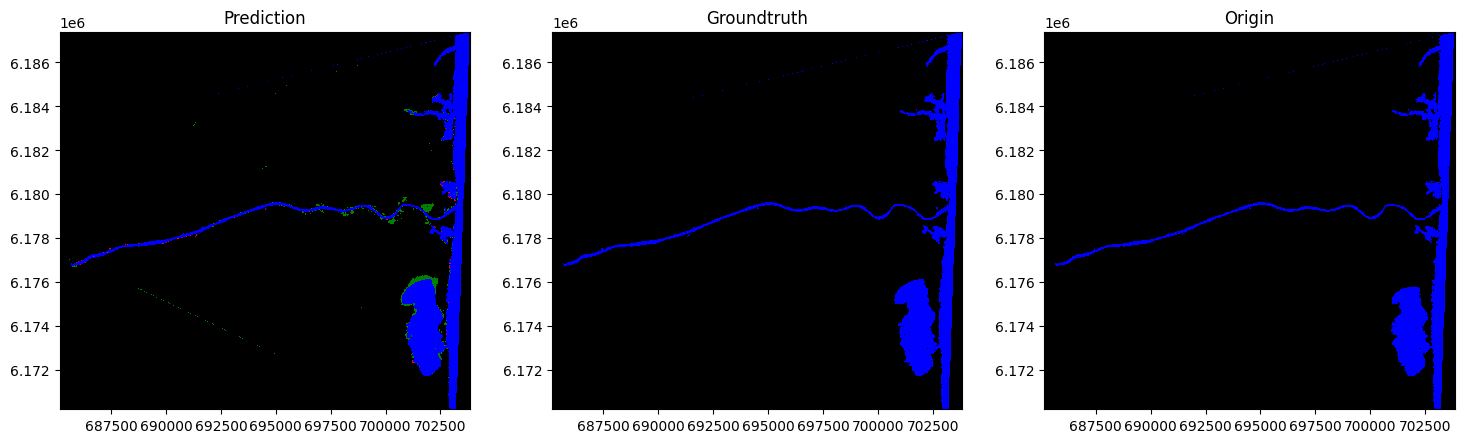

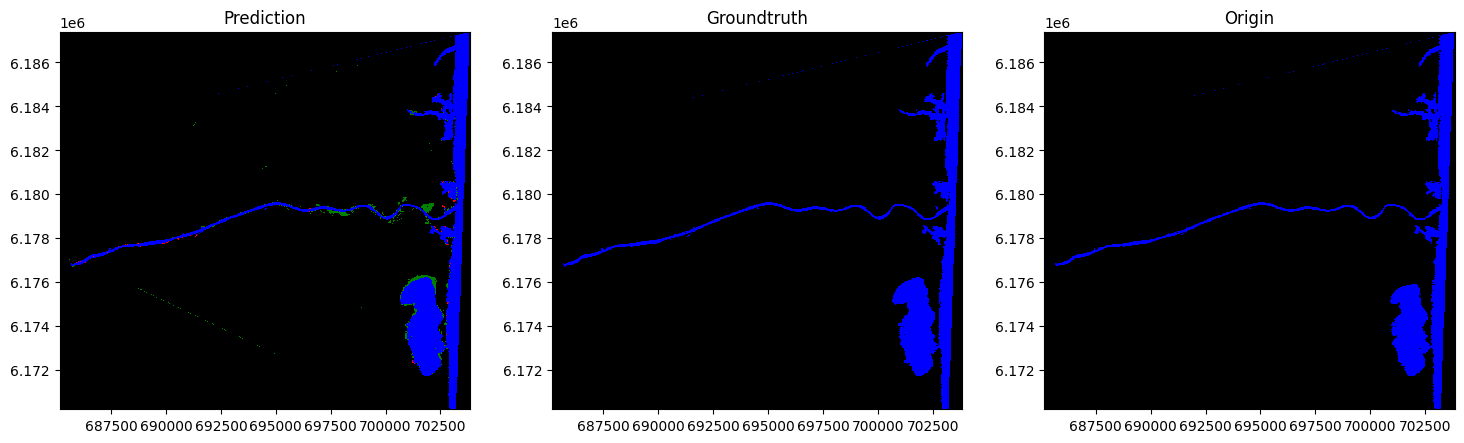

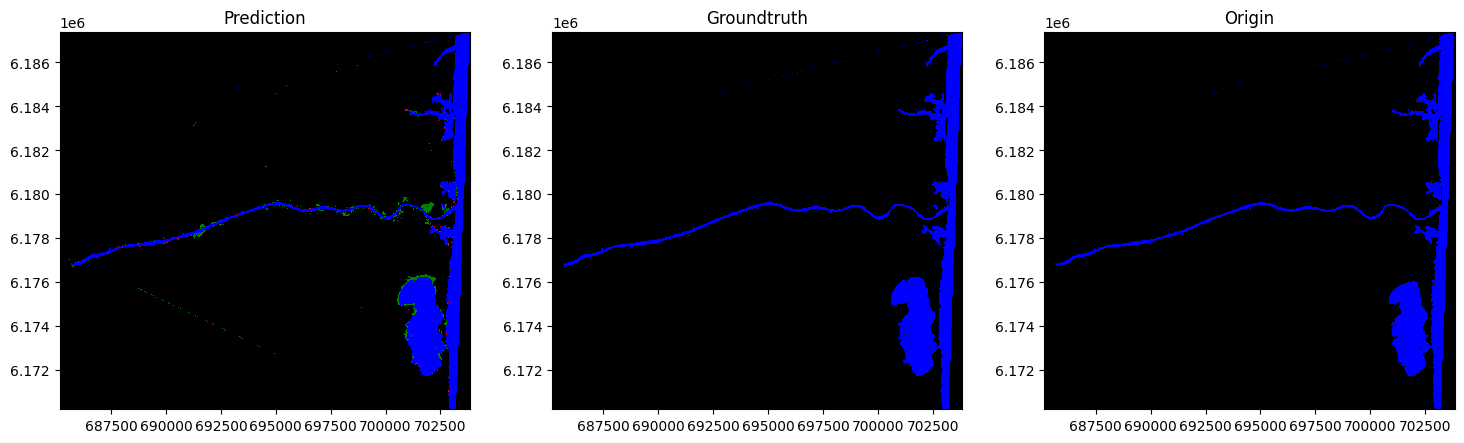

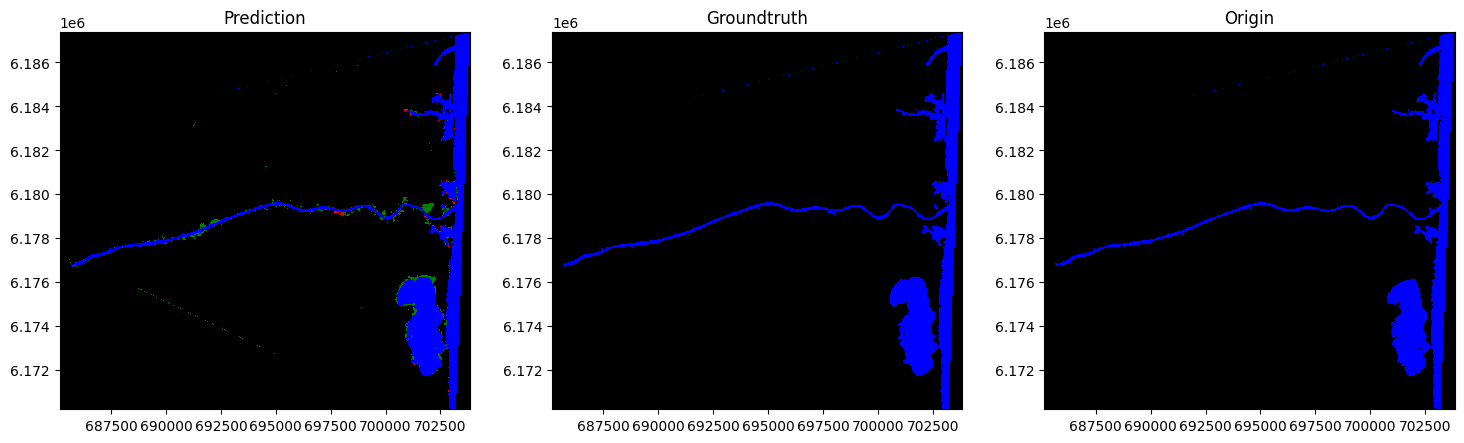

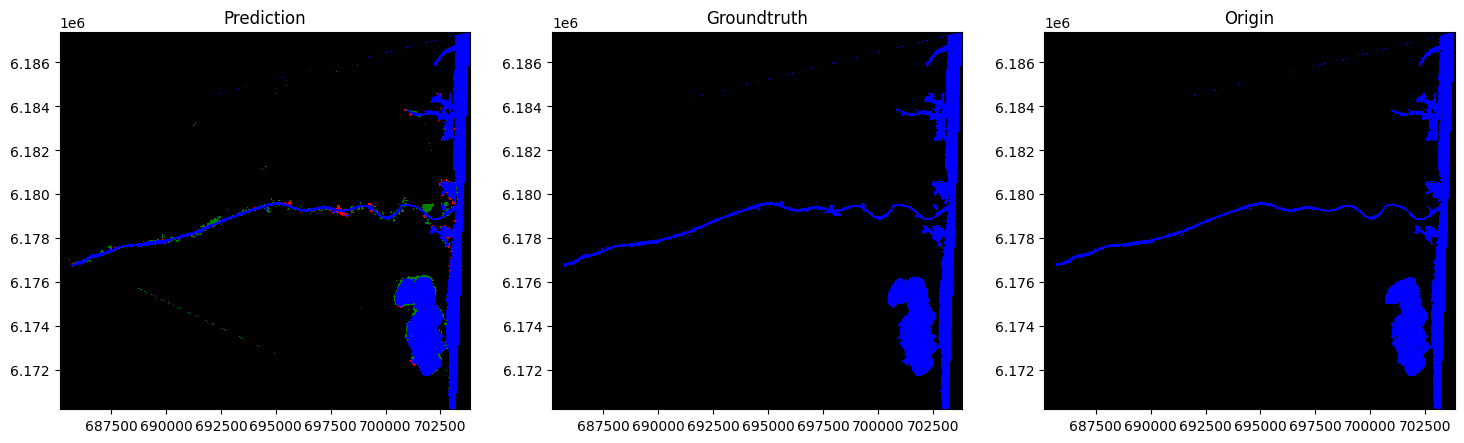

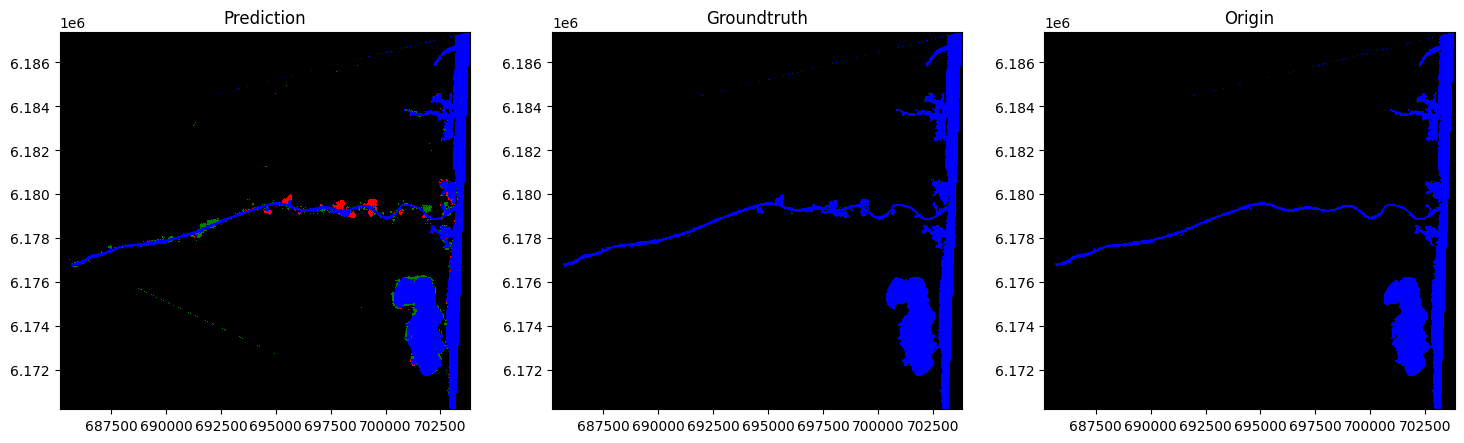

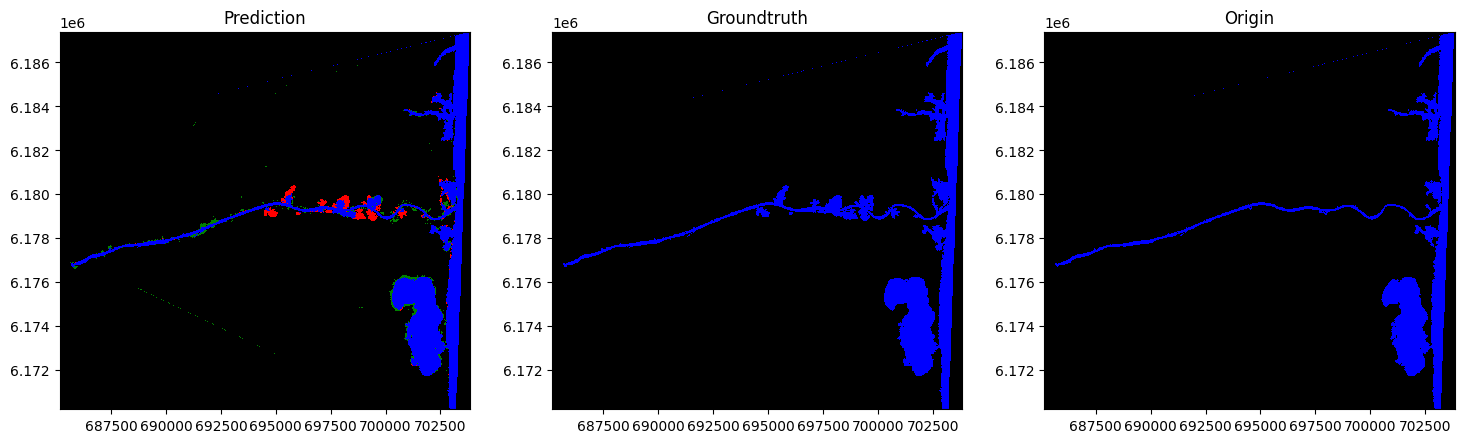

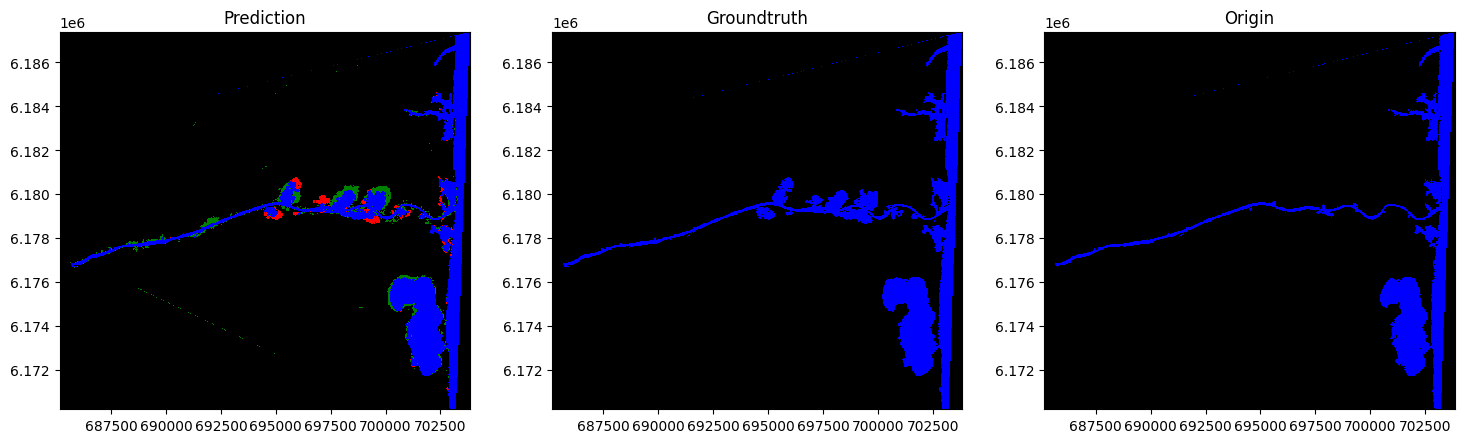

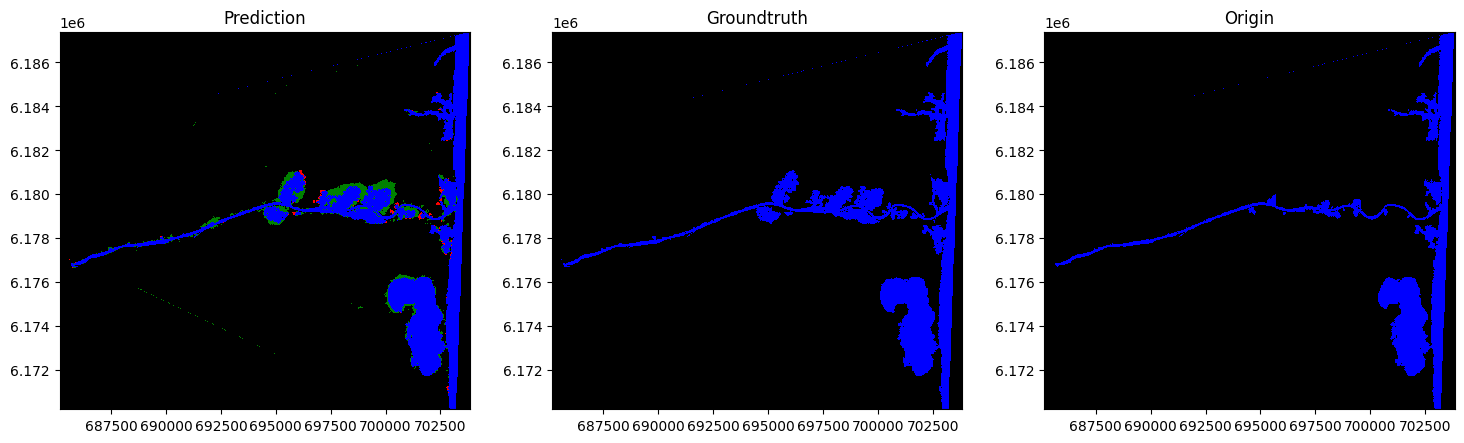

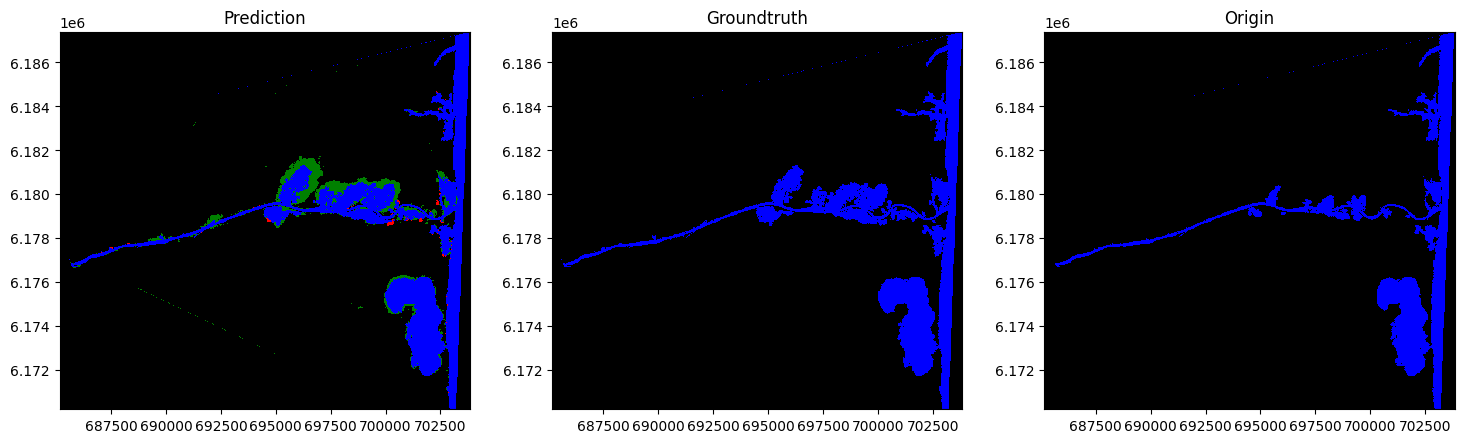

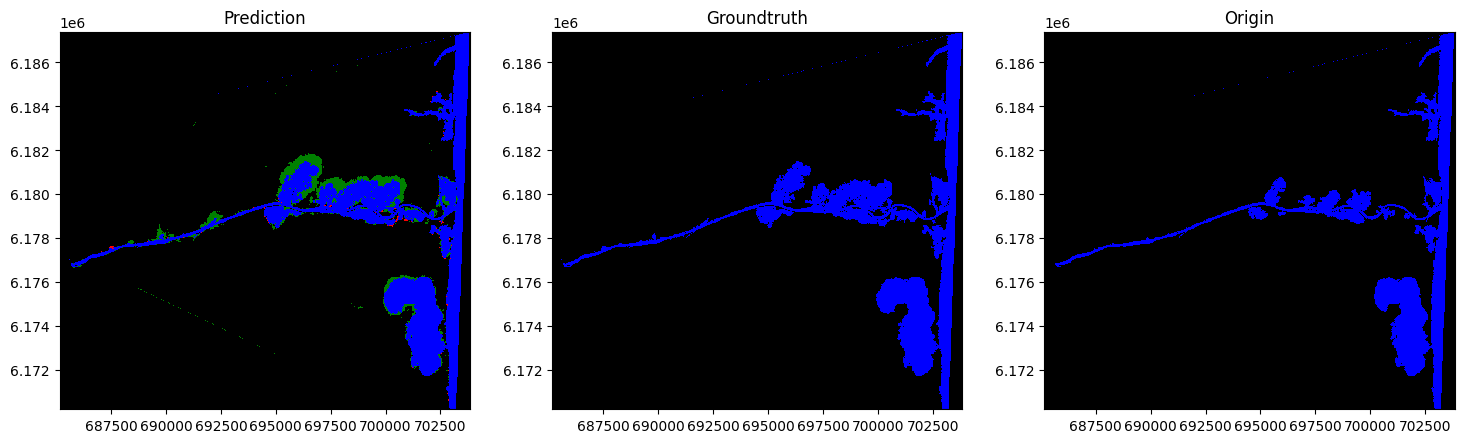

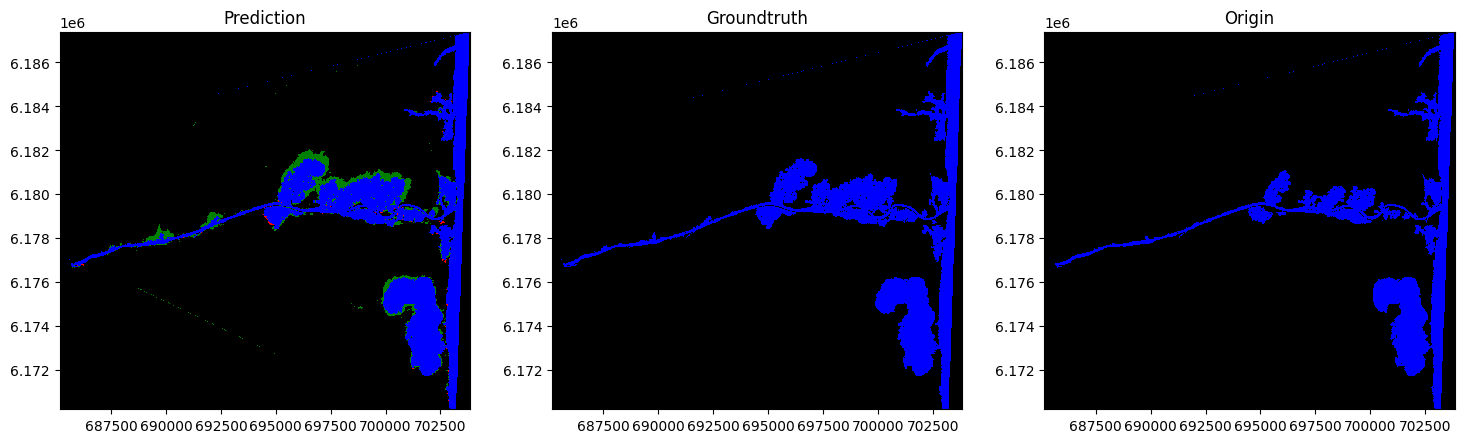

KeyboardInterrupt: 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

epsilon = 1e-2

def interpolate_and_classify(X, data, xi, yi, epsilon):
    """ Interpolate data and classify pixels based on epsilon """
    interp_data = griddata((X[:, 0], X[:, 1]), data[:, 0], (xi, yi), method='linear')
    binary_data = np.zeros_like(interp_data)
    binary_data[interp_data >= epsilon] = 1  # Positive
    return interp_data, binary_data

def classify_prediction(pred_interp, gd_interp, epsilon):
    """ Classify pixels based on prediction and groundtruth """
    tp = (pred_interp >= epsilon) & (gd_interp >= epsilon)
    fn = (pred_interp < epsilon) & (gd_interp >= epsilon)
    fp = (pred_interp >= epsilon) & (gd_interp < epsilon)
    
    color_codes = np.zeros_like(pred_interp)
    color_codes[tp] = 1  # True Positive - Blue
    color_codes[fn] = 2  # False Negative - Red
    color_codes[fp] = 3  # False Positive - Green
    
    return color_codes

def plot_data(ax, data, title, cmap, bounds, norm):
    """ Plot interpolated data with a given colormap """
    ax.set_title(title)
    ax.pcolormesh(xi, yi, data, shading='auto', cmap=cmap, norm=norm)
    ax.set_aspect('equal')

# Create a grid
xi = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 700)
yi = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 700)
xi, yi = np.meshgrid(xi, yi)

for pdt in range(len(groundtruth)):
    gd = groundtruth[pdt]
    pred = predict[pdt]
    ori = origin[pdt]
    
    # Interpolate and classify the data
    pred_interp, binary_pred = interpolate_and_classify(X, pred, xi, yi, epsilon)
    gd_interp, binary_gd = interpolate_and_classify(X, gd, xi, yi, epsilon)
    ori_interp, binary_ori = interpolate_and_classify(X, ori, xi, yi, epsilon)
    
    # Classify prediction into TP, FN, FP
    color_codes = classify_prediction(pred_interp, gd_interp, epsilon)
    
    # Create colormaps
    prediction_cmap = plt.cm.colors.ListedColormap(['k', 'b', 'r', 'g'])  # Black, Blue, Red, Green
    groundtruth_cmap = plt.cm.colors.ListedColormap(['k', 'b'])  # Black, Blue
    norm_prediction = plt.cm.colors.BoundaryNorm([0, 0.5, 1.5, 2.5, 3.5], prediction_cmap.N)
    norm_groundtruth = plt.cm.colors.BoundaryNorm([0, 0.5, 1.5], groundtruth_cmap.N)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    plot_data(axes[0], color_codes, 'Prediction', prediction_cmap, [0, 1, 2, 3], norm_prediction)
    plot_data(axes[1], binary_gd, 'Groundtruth', groundtruth_cmap, [0, 1], norm_groundtruth)
    plot_data(axes[2], binary_ori, 'Origin', groundtruth_cmap, [0, 1], norm_groundtruth)
    
    plt.show()


In [ ]:
from scipy.interpolate import griddata

epsilon = 1e-2

def interpolate_data(X, data, xi, yi):
    """ Interpolate data """
    return griddata((X[:, 0], X[:, 1]), data[:, 0], (xi, yi), method='linear')

def plot_data(ax, data, title, cmap, norm):
    """ Plot interpolated data with a given colormap """
    ax.set_title(title)
    c = ax.pcolormesh(xi, yi, data, shading='auto', cmap=cmap, norm=norm)
    fig.colorbar(c, ax=ax, orientation='vertical')
    ax.set_aspect('equal')

# Create a grid
xi = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 700)
yi = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 700)
xi, yi = np.meshgrid(xi, yi)

for pdt in range(len(groundtruth)):
    gd = groundtruth[pdt]
    pred = predict[pdt]
    ori = origin[pdt]
    
    # Interpolate data
    pred_interp = interpolate_data(X, pred, xi, yi)
    gd_interp = interpolate_data(X, gd, xi, yi)
    ori_interp = interpolate_data(X, ori, xi, yi)
    
    # Create colormaps
    data_cmap = plt.cm.viridis  # Example colormap, adjust as needed
    norm_data = plt.Normalize(vmin=min(np.min(pred_interp), np.min(gd_interp), np.min(ori_interp)), 
                               vmax=max(np.max(pred_interp), np.max(gd_interp), np.max(ori_interp)))
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    plot_data(axes[0], pred_interp, 'Prediction', data_cmap, norm_data)
    plot_data(axes[1], gd_interp, 'Groundtruth', data_cmap, norm_data)
    plot_data(axes[2], ori_interp, 'Origin', data_cmap, norm_data)
    
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

unroll_steps = 15
epsilon = 5e-3

# Define the full colormap for prediction (black, blue, red, orange)
prediction_cmap = mcolors.ListedColormap(['k', 'b', 'r', 'orange'])
prediction_bounds = [0, 1, 2, 3, 4]  # Boundaries for color mapping
prediction_norm = mcolors.BoundaryNorm(prediction_bounds, prediction_cmap.N)

# Define the simple colormap for the starting point (black, blue)
start_cmap = mcolors.ListedColormap(['k', 'b'])
start_bounds = [0, 0.5, 1]  # Boundaries for color mapping
start_norm = mcolors.BoundaryNorm(start_bounds, start_cmap.N)

for pdt in range(len(groundtruth)):
    gd = groundtruth[pdt]
    pred = predict[pdt]
    ori = origin[pdt]
    
    # Calculate CSI for this timestep (or use it in plotting as needed)
    csi = calculate_csi(pred[:, 0], gd[:, 0], epsilon=epsilon)
    
    # Define conditions
    tp = (pred[:, 0] >= epsilon) & (gd[:, 0] >= epsilon)
    fp = (pred[:, 0] >= epsilon) & (gd[:, 0] < epsilon)
    fn = (pred[:, 0] < epsilon) & (gd[:, 0] >= epsilon)
    
    # Initialize a numeric array for triangle colors for the prediction
    color_codes = np.zeros(triangles.shape[0])  # Default is 0 (black)
    
    for i, tri in enumerate(triangles):
        tp_avg = np.mean(tp[tri])
        fp_avg = np.mean(fp[tri])
        fn_avg = np.mean(fn[tri])
        
        if tp_avg == 1:  # All vertices are true positive
            color_codes[i] = 1  # Blue for true positive
        elif fp_avg == 1:  # All vertices are false positive
            color_codes[i] = 2  # Red for false positive
        elif fn_avg == 1:  # All vertices are false negative
            color_codes[i] = 3  # Orange for false negative
    
    # Plot prediction with full color mapping
    plt.figure()
    plt.title(f'Prediction at {20 * unroll_steps} min, timestep number {500 + pdt * 20}, CSI: {csi:.2f}')
    plt.tripcolor(X[:, 0], X[:, 1], pred[:, 0] - ori[:, 0], triangles=triangles, facecolors=color_codes, cmap=prediction_cmap, norm=prediction_norm)
    plt.show()
    
    # Plot starting point with triangles > epsilon in blue and others in black
    plt.figure()
    plt.title(f'Starting point, timestep number {500 + pdt * 20}')
    
    # Initialize a numeric array for triangle colors for the starting point
    start_color_codes = np.zeros(triangles.shape[0])  # Default is 0 (black)
    
    for i, tri in enumerate(triangles):
        ori_avg = np.mean(ori[tri, 0])  # Calculate the average value of the vertices in the triangle
        if ori_avg > epsilon:  # If the average value is greater than epsilon
            start_color_codes[i] = 1  # Blue
    
    # Plot starting point with simple color mapping
    plt.tripcolor(X[:, 0], X[:, 1], start_color_codes, triangles=triangles, cmap=start_cmap, norm=start_norm)
    plt.show()
    
    pdt += 1


In [ ]:
for pdt in range(len(groundtruth)) :
    gd = groundtruth[pdt]
    pred = predict[pdt]
    ori = origin[pdt]
    h_max = max(np.max(gd[:,0]),np.max(pred[:,0]))
    h_min = min(np.min(gd[:,0]),np.min(pred[:,0]))
    plt.figure()
    plt.title('prediction à 20 min, pas de temps numero {}'.format(500+pdt*20))
    plt.tripcolor(X[:,0],X[:,1],pred[:,0]-ori[:,0],triangles=triangles,vmax=h_max,vmin=h_min)
    #plt.xlim(685000,687500)
    #plt.ylim(6170000,6180000)
    plt.show()
                                                 
    plt.figure()
    plt.title('groundtruth à 20 min, pas de temps numero {}'.format(500+pdt*20))
    plt.tripcolor(X[:,0],X[:,1],gd[:,0]-ori[:,0],triangles=triangles,vmax=h_max,vmin=h_min)
    #plt.xlim(685000,687500)
    #plt.ylim(6170000,6180000)
    plt.show()
                                                 
    pdt+=1

In [ ]:
!ls /work/m24046/m24046mrcr/dataset_20_min/